# Capstone Project: Clustering the world's largest cities

### Aniruddh Jammoria

## List of contents

* [Introduction](#1)

* [Data used](#2)

* [Methodology](#3)
    * [Importing the datasets from Wikipedia and Numbeo](#3.1)
        * [Importing the list of the world's largest cities from Wikipedia](#3.1.1))
        * [Importing citywise GDP data from Wikipedia](#3.1.2)
        * [Importing citywise cost indices from Numbeo](#3.1.3)
    * [Adding latitude and longitude values to the dataset](#3.2)
    * [Querying venues around the city using FourSquare API](#3.3)
    * [Exploratory data analysis on the demographic data](#3.4)
        * [Column-wise distributions](#3.4.1)
        * [Correlation between costs and GDP per capita](#3.4.2)
        * [Correlation between costs and population density](#3.4.3)
        * [Correlation between population density and GDP](#3.4.4)
        * [Correlation between city area and other demographic variables](#3.4.5)
* Clustering the dataset
    * Clustering using only demographic data
    * Clustering using venue data
* Results and Discussion
* Conclusion

<a id = '1'></a>
## 1. Introduction

Millennials (people born between 1980 and 2000) comprise over one third of the global professional workforce - representing 25% of US and over 50% of the Indian working professionals. The global financial crisis of 2008 and the expected crisis because of the Coronavirus pandemic has affected the loyalty that millennials feel towards their employers. According to a [PWC survey](https://www.pwc.com/co/es/publicaciones/assets/millennials-at-work.pdf) conducted in 2011, more than 50% of millennials expected to have 2-5 employers within their lifetime. Millennials are also a globally mobile workforce - according to a [2019 survey conducted by Deloitte](https://www2.deloitte.com/global/en/pages/about-deloitte/articles/millennialsurvey.html), 'Seeing/Experiencing the world' was the topmost priority of millennials, with over 60% respondents expressing the desire to do so. USA, Brazil, UK, Germany, China and Singapore are the top destinations where millennials are sent for work assignments.

<b>While career progression remains the topmost reason for international movement, several other factors come into play while zeroing down on the next big move. These include, but are not limited to expenses, incomes, population density (a measure of congestion), quality of life and cultural experience.</b> My own move to Singapore last year was driven primarily by my desire to explore South East Asia in greater detail. Travelling across various cities, I came to the realization that cities could have varying degrees of likeness - for example, the density and distribution of traffic in Jakarta (and the traffic jams that consequently arose) were very similar to what I saw in Mumbai and Bangalore. While smaller cities retained most of their 'local' flavour, larger and more cosmopolitan cities had restaurants and cafes serving foods from all leading cuisines.

<b>This report aims at clustering 80 of the world's largest and most populated cities into two or more clusters, based on similarity across demographic attributes and venue density around the city centres.</b> For the sake of simplicity, the following basic demographic parameters are considered
<b>
1. Population
2. City Area
3. Population Density (a measure of how congested the city is)
4. PPP adjusted GDP
5. GDP per capita (a measure of the income levels within the city)
6. Cost indices (a measure of the expenses within the city)
</b>
Both of these clustering approaches are discussed separately. Targeted mostly at millennials who are looking to move overseas, I hope that this report helps them get a flavour of what is yet to come.

<a id = '2'></a>
## 2. Data used

The code in this project uses the following data

1. <b>A list of the world's 80 largest cities, as defined by the United Nations in 2018</b>. This data was obtained from Wikipedia. [The wiki](https://en.wikipedia.org/wiki/List_of_largest_cities) includes the city names, the country they are present in, and the populations and areas of different types of urban boundaries. Three different types of city boundaries are defined - Administrative, Metropolitan and Urban. The maximum value of population and area for each city (among the three different types of definitions) was considered in order to ensure availability of data. <br/>

2. <b>GDP (Gross Domestic Product) for cities across the world. This data was also obtained from Wikipedia.</b> [The wiki](https://en.wikipedia.org/wiki/List_of_cities_by_GDP) page has nominal as well as absolute GDP values for >300 countries, This dataset has been populated from various sources, and has GDP values from different years. For some countries, the latest GDP measure might not be the most recent. However, for most major countries, the GDP value from 2018 is provided. Since this has to be compared across countries, the Purchasing Power Parity adjusted GDP was taken as an input. <br/>

3. <b>Cost indices for cost of living, rent, groceries and restaurant prices.</b> This data was obtained from [Numeo](https://www.numbeo.com/cost-of-living/rankings.jsp?title=2019). The numbers are for 2019, relative to costs in New York City. A cost index of 125 means that the costs there are 25% higher than in NYC.

4. <b>Coordinate data for each of the cities ie the Latitude and Longitude values.</b> This data was obtained using the geopy library of Python, and was used for plotting color-coded maps using the folium library. There are some city names (such as Paris) which are common - there are various cities of that name. In order to prevent duplication, the city name + country name was passed as an argument to the geolocator. <br/>

5. <b>A list of venues around the city centre.</b> This data was obtained using the Foursquare API. All kinds of venues - parks, restaurants, hospitals etc were considered as a part of this exercise. Since we are looking at different types of venues around the city centre, a search radius of 10 kilometres was used, and a maximum of 500 venues in this radius were extracted. This was done to get a representative sample of the venues in each location.

<a id = '3'></a>
## 3. Methodology

This section discusses data sourcing and cleanup techniques, followed by exploratory data analysis on the datasets obtained.

In [67]:
#Import all the necessary libraries
import numpy as np 
import pandas as pd
import json 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
from bs4 import BeautifulSoup
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', 0)
from IPython.display import Image

<a id = '3.1'></a>
### 3.1 Importing the datasets from Wikipedia and Numbeo

<a id = '3.1.1'></a>
#### 3.1.1 Importing the list of the world's largest cities from Wikipedia

The base dataset is the list of the world's 80 largest cities, obtained by reading [this wiki](https://en.wikipedia.org/wiki/List_of_largest_cities). Looking at the page source, we find that the table data is present under the class 'sortable wikitable mw-datatable'. The table defines three different type of city boundaries - Administrative, urban and metropolitan. Population and area details for all three of these definitions are read and then loaded into the dataframe <b>citydata</b>

In [2]:
wiki_link = 'https://en.wikipedia.org/wiki/List_of_largest_cities'

#get the html and convert to parser
web_html = requests.get(wiki_link).text
soup = BeautifulSoup(web_html, 'html.parser')

#the table is under the class wikitable sortable
table = soup.find('table', {'class':'sortable wikitable mw-datatable'})

#create blank arrays to hold the data
name = []
population_un = []
population_cp = []
population_met = []
population_urb = []
area_cp = []
area_met = []
area_urb = []
country = []

rows = table.find_all('tr') #find rows with the TR tag

for r in rows:
    cell = r.find_all('td') #find cells with the TD tag
    if (len(cell) > 1):
        nam = cell[0] #first element is the name
        ctr = cell[1]
        pop_un = cell[3]
        pop_cp = cell[5]
        pop_met = cell[7]
        pop_urb = cell[9]
        ar_cp = cell[6]
        ar_met = cell[8]
        ar_urb = cell[10]
       
        name.append(nam.text.strip())
        population_un.append(pop_un.text.strip())
        population_cp.append(pop_cp.text.strip())
        population_met.append(pop_met.text.strip())
        population_urb.append(pop_urb.text.strip())
        area_cp.append(ar_cp.text.strip())
        area_met.append(ar_met.text.strip())
        area_urb.append(ar_urb.text.strip())
        country.append(ctr.text.strip())

#define a blank dataframe and populate it with the data read from the page
citydata = pd.DataFrame({'Name':name, "PUN":population_un, "PCP":population_cp, "PMET":population_met, "PURB":population_urb,
                         'ACP':area_cp, 'AMET':area_met, 'AURB':area_urb, 'Country':country})

citydata.head()

,Name,PUN,PCP,PMET,PURB,ACP,AMET,AURB,Country
0,Tokyo,"37,400,068","13,515,271[14]","37,274,000[15]","38,505,000","2,191[14]","13,452[15]","8,223[d]",Japan
1,Delhi,"28,514,000","16,753,235[16]","29,000,000[17]","28,125,000","1,484","3,483[17]","2,240[e]",India
2,Shanghai,"25,582,000","24,183,000[18]",N/A,"22,125,000","6,341",N/A,"4,015[f]",China
3,São Paulo,"21,650,000","12,252,023[19]","21,734,682[20]","20,935,000","1,521","7,947","3,043[g]",Brazil
4,Mexico City,"21,581,000","8,918,653[21]","20,892,724[22]","20,395,000","1,485","7,854","2,370",Mexico


In [3]:
print('The original City dataset has', citydata.shape[0], 'rows and', citydata.shape[1], 'columns')

The original City dataset has 81 rows and 9 columns


There are several special characters in the text - numbers separated by commas, and square brackets for providing references. These values are removed by using the <b>replace and split</b> methods. All the 'N/A' values are converted to zero and all the columns that are supposed to have numerical data are converted from string to float data type to facilitate further calculations. 'New York City' is renamed to 'New York' to ensure consistency with later dataframes.

In [4]:
#Remove special characters from the text
str_columns = ['PUN', 'PCP', 'PMET', 'PURB', 'ACP', 'AMET', 'AURB']

for index, rowdata in citydata.iterrows():
    for column in str_columns:
        citydata.at[index, column] = citydata.at[index, column].replace(',', '') #remove the comma
        citydata.at[index, column] = citydata.at[index, column].split('[')[0] #split for square brackets, take first term
        
        if (citydata.at[index, column] == 'N/A') or (citydata.at[index, column] == ''):
            citydata.at[index, column] = 0 #convert all NA and blank values to zero
            
#rename NYC to NY
for index, rowdata in citydata.iterrows():
    if (citydata.at[index, 'Name'] == 'New York City'):
        citydata.at[index, 'Name'] = 'New York'
            
            
#convert the numerical values to float
citydata[str_columns] = citydata[str_columns].astype(float)

Since the population and area estimates are done from various sources, they are not complete. To ensure availability of data, the population and area of a city are defined as the maximum value of the three (or less) data sources that are available. A new parameter <b>Density (Population Density)</b> is defined as Population/Area. The rows for which population or area are zero are filtered out, and the resulting dataframe is stored in <b>df_cities</b>

In [5]:
#Select the maximum values to define area and population
for index, rowdata in citydata.iterrows():
    citydata.at[index, 'Population'] = max(citydata.at[index, 'PUN'], citydata.at[index, 'PCP'], citydata.at[index, 'PMET'], citydata.at[index, 'PURB'] )
    citydata.at[index, 'Area'] = max(citydata.at[index, 'ACP'], citydata.at[index, 'AMET'], citydata.at[index, 'AURB'])

#Create a new dataframe and add the density variable
df_cities = citydata.copy()
df_cities.drop(str_columns, axis = 1, inplace = True)
df_cities['Density'] = df_cities['Population']/df_cities['Area']

#remove the cities where the area is zero
row_filter = (df_cities['Area']*df_cities['Population'] != 0)
df_cities = df_cities[row_filter].reset_index()
df_cities = df_cities.drop('index', axis = 1)
df_cities.head()

,Name,Country,Population,Area,Density
0,Tokyo,Japan,38505000.0,13452.0,2862.399643
1,Delhi,India,29000000.0,3483.0,8326.155613
2,Shanghai,China,25582000.0,6341.0,4034.379435
3,São Paulo,Brazil,21734682.0,7947.0,2734.954322
4,Mexico City,Mexico,21581000.0,7854.0,2747.771836


In [6]:
print('The processed City dataset has', df_cities.shape[0], 'rows and', df_cities.shape[1], 'columns')

The processed City dataset has 76 rows and 5 columns


<a id = '3.1.2'></a>
#### 3.1.2 Importing citywise GDP data from Wikipedia

GDP values for the world's major cities can be found on [this wiki](https://en.wikipedia.org/wiki/List_of_cities_by_GDP). The GDP estimation has been done by various sources, but to ensure uniformity of comparison we use the <b>Purchasing Power Parity (PPP) adjusted GDP</b>. As mentioned in the previous section, we import the GDP table, remove all blank and NaN data, and change the datatype of the GDP column to float. The resulting dataframe is named <b>df_gdp</b>.

In [7]:
#importing the GDP dataset
wiki_link = 'https://en.wikipedia.org/wiki/List_of_cities_by_GDP'

#get the html and convert to parser
web_html = requests.get(wiki_link).text
soup = BeautifulSoup(web_html, 'html.parser')

#the table is under the class wikitable sortable
table = soup.find('table', {'class':'wikitable sortable'})

#create blank arrays to hold the data
name = []
gdp = []

rows = table.find_all('tr') #find rows with the TR tag

for r in rows:
    cell = r.find_all('td') #find cells with the TD tag
    if (len(cell) > 1):
        nam = cell[0] #first element is the name
        gd = cell[4] #fifth element is the GDP
        
       
        name.append(nam.text.strip())
        gdp.append(gd.text.strip())

#define a blank dataframe and populate it with the data read from the page
df_gdp = pd.DataFrame({'Name':name, "GDP_bn":gdp})

#drop all rows with blank GDP values
nan_value = float('NaN')
df_gdp.replace('', nan_value, inplace = True)
df_gdp.dropna(inplace = True)

#remove special characters
for index, rowdata in df_gdp.iterrows():
    df_gdp.at[index, 'GDP_bn'] = df_gdp.at[index, 'GDP_bn'].split('[')[0]
    df_gdp.at[index, 'GDP_bn'] = df_gdp.at[index, 'GDP_bn'].replace(',', '')
    
#make the GDP column as float
df_gdp['GDP_bn'] = df_gdp['GDP_bn'].astype(float)
df_gdp.reset_index(drop = True).head()

,Name,GDP_bn
0,Aachen-Liège-Maastricht,99.7
1,Abu Dhabi,178.3
2,Adelaide,47.4
3,Akron,32.8
4,Albany,58.4


In [8]:
print('The original GDP dataset has', df_gdp.shape[0], 'rows and', df_gdp.shape[1], 'columns')

The original GDP dataset has 314 rows and 2 columns


The GDP information is then merged with the city data dataframe (df_cities) which was defined in section 3.1. Since we need to ensure that GDP data is available for all cities that we want to analyze, we do an inner join of both of these dataframes (this will lead to some cities being lost from the original dataframe). Additionally, we define a new parameter <b>GDP_pc ie the Per Capita GDP</b> which is calculated by dividing the city's GDP by its population. Note that the original GDP was in Billions of dollars, whereas the per capita GDP is in dollars.

In [9]:
#merge both dataframes on the city name key
df_cities = df_cities.merge(df_gdp, how = 'inner', left_on = 'Name', right_on = 'Name')

#define the per capita GDP
df_cities['GDP_pc'] = df_cities['GDP_bn']*1000000000/df_cities['Population']
df_cities.head()

,Name,Country,Population,Area,Density,GDP_bn,GDP_pc
0,Tokyo,Japan,38505000.0,13452.0,2862.399643,1617.0,41994.546163
1,Delhi,India,29000000.0,3483.0,8326.155613,293.6,10124.137931
2,Shanghai,China,25582000.0,6341.0,4034.379435,594.0,23219.451177
3,São Paulo,Brazil,21734682.0,7947.0,2734.954322,430.5,19807.053078
4,Mexico City,Mexico,21581000.0,7854.0,2747.771836,403.6,18701.635698


In [10]:
print('The merged City dataset has', df_cities.shape[0], 'rows and', df_cities.shape[1], 'columns')

The merged City dataset has 60 rows and 7 columns


<a id = '3.1.3'></a>
#### 3.1.3 Importing citywise cost indices from Numbeo

Numeo has tabulated various cost indices for 433 cities across the world, the dataset can be found [here](https://www.numbeo.com/cost-of-living/rankings.jsp?title=2019). Looking at the page's source, the table is found under the class 'stripe row-border order-column compact'. Four different cost indices - cost of living, rent, groceries and restaurant prices are read from this table and stored in the dataframe <b>df_indices</b>

In [11]:
#importing the GDP dataset
wiki_link = 'https://www.numbeo.com/cost-of-living/rankings.jsp?title=2019'

#get the html and convert to parser
web_html = requests.get(wiki_link).text
soup = BeautifulSoup(web_html, 'html.parser')

#the table is under the class wikitable sortable
table = soup.find('table', {'class':'stripe row-border order-column compact'})

#create blank arrays to hold the data
name = []
coli = []
rent = []
groc = []
rest = []

rows = table.find_all('tr') #find rows with the TR tag

for r in rows:
    cell = r.find_all('td') #find cells with the TD tag
    if (len(cell) > 1):
        nam = cell[1] #first element is the name
        col = cell[2] #fifth element is the GDP
        ren = cell[3]
        gro = cell[5]
        res = cell[6]
        
        name.append(nam.text.strip())
        coli.append(col.text.strip())
        rent.append(ren.text.strip())
        groc.append(gro.text.strip())
        rest.append(res.text.strip())

#define a blank dataframe and populate it with the data read from the page
df_indices = pd.DataFrame({'Name':name, "COL":coli, "RENT":rent, "GROC":groc, "REST":rest})
df_indices.head()

,Name,COL,RENT,GROC,REST
0,"Basel, Switzerland",131.37,45.62,127.40,128.41
1,"Zurich, Switzerland",126.87,59.72,128.53,126.15
2,"Lausanne, Switzerland",123.42,48.62,128.21,120.11
3,"Bern, Switzerland",123.17,39.37,122.06,114.49
4,"Geneva, Switzerland",118.87,67.10,116.00,123.04


Using the <b>split</b> method, the 'Name' column is split into City and Country by using the comma delimiter. The columns that contain the indices data are converted to float values for easier calculation. The columns are also re-arranged for better readability.

Since the comma delimiter also splits (Washington, DC) into two strings, we preserve this by adding an if statement. Furthermore, we delete the entry that corresponds to London in Canada to prevent any error in inner joins later.

In [12]:
#Split the Name column to City and country
for index, rows in df_indices.iterrows():
    city = df_indices.at[index, 'Name'].split(', ')[0]
    country = df_indices.at[index, 'Name'].split(', ')[1]
    if (city == 'Washington'):
        city = 'Washington, D.C.'
    df_indices.at[index, 'Name'] = city
    df_indices.at[index, 'Country'] = country

#Rearrange the columns, convert to float and output the dataframe
df_indices = df_indices[['Name', 'Country', 'COL', 'RENT', 'GROC', 'REST']]
df_indices[['COL', 'RENT', 'GROC', 'REST']] = df_indices[['COL', 'RENT', 'GROC', 'REST']].astype(float)

#Locate London in Canada and remove this from the dataframe
london_search = df_indices['Name'] == 'London'
canada_search = df_indices['Country'] == 'Canada'
lc_search = [not(a and b) for a,b in zip(london_search, canada_search)]
df_indices = df_indices[lc_search]

df_indices.head()

,Name,Country,COL,RENT,GROC,REST
0,Basel,Switzerland,131.37,45.62,127.40,128.41
1,Zurich,Switzerland,126.87,59.72,128.53,126.15
2,Lausanne,Switzerland,123.42,48.62,128.21,120.11
3,Bern,Switzerland,123.17,39.37,122.06,114.49
4,Geneva,Switzerland,118.87,67.10,116.00,123.04


In [13]:
print('The cost indices dataframe has', df_indices.shape[0], 'rows and', df_indices.shape[1], 'columns')

The cost indices dataframe has 432 rows and 6 columns


This dataframe is merged with the city data dataframe (df_cities) by using an inner join. We drop the 'Countries' column from the indices table to avoid duplication of data.

In [14]:
#merge both dataframes on the city name key
df_cities = df_cities.merge(df_indices.drop('Country', axis = 1), how = 'inner', left_on = 'Name', right_on = 'Name')
df_cities.head()

,Name,Country,Population,Area,Density,GDP_bn,GDP_pc,COL,RENT,GROC,REST
0,Tokyo,Japan,38505000.0,13452.0,2862.399643,1617.0,41994.546163,88.45,37.16,88.87,54.90
1,Delhi,India,29000000.0,3483.0,8326.155613,293.6,10124.137931,28.00,8.20,25.84,25.88
2,Shanghai,China,25582000.0,6341.0,4034.379435,594.0,23219.451177,50.29,32.22,54.07,39.71
3,Mexico City,Mexico,21581000.0,7854.0,2747.771836,403.6,18701.635698,35.30,17.65,32.06,31.33
4,Cairo,Egypt,20076000.0,3085.0,6507.617504,102.2,5090.655509,27.87,5.78,23.95,25.36


In [15]:
print('The final City dataframe has', df_cities.shape[0], 'rows and ', df_cities.shape[1], 'columns. The merge operations have led to a loss of', citydata.shape[0]-df_cities.shape[0], 'rows')

The final City dataframe has 46 rows and  11 columns. The merge operations have led to a loss of 35 rows


<a id = '3.2'></a>
### 3.2 Adding latitude and longitude values to the dataset

Now that we have the list of 46 cities that we wish to cluster, latitude and longitude data is required to plot them and obtain venues from the Foursquare API. <b>The Nominatim function from the geopy library is used to get this data.</b> During some initial runs of the code, it was observed that the API request to geocode timed out. The Nominatim terms of use mention that only one search request can be raised per second. Therefore, <b>a sleep of 1 second was added to the iterator after every API call to ensure that the request doesn't time out.</b><br>
In order to avoid repetition of the user_agent, a string is added to the search query. I plan to replace it with a random text generator for each iteration.

In [16]:
# define the latitude and longitude of each city
from geopy.geocoders import Nominatim

for index, rowdata in df_cities.iterrows():
    searchquery = df_cities.at[index, 'Name'] + ',' + df_cities.at[index, 'Country']
    geolocator = Nominatim(user_agent = searchquery+'a13')
    location = geolocator.geocode(searchquery)
    df_cities.at[index, 'Latitude'] = location.latitude
    df_cities.at[index, 'Longitude'] = location.longitude
    time.sleep(1)

df_cities.head()

,Name,Country,Population,Area,Density,GDP_bn,GDP_pc,COL,RENT,GROC,REST,Latitude,Longitude
0,Tokyo,Japan,38505000.0,13452.0,2862.399643,1617.0,41994.546163,88.45,37.16,88.87,54.90,35.682839,139.759455
1,Delhi,India,29000000.0,3483.0,8326.155613,293.6,10124.137931,28.00,8.20,25.84,25.88,28.651718,77.221939
2,Shanghai,China,25582000.0,6341.0,4034.379435,594.0,23219.451177,50.29,32.22,54.07,39.71,31.232276,121.469207
3,Mexico City,Mexico,21581000.0,7854.0,2747.771836,403.6,18701.635698,35.30,17.65,32.06,31.33,19.432630,-99.133178
4,Cairo,Egypt,20076000.0,3085.0,6507.617504,102.2,5090.655509,27.87,5.78,23.95,25.36,30.048819,31.243666


In [17]:
#check the average city radius
avg_city_area = df_cities['Area'].mean()
avg_city_radius = math.sqrt(avg_city_area/math.pi)
print('The average city radius is =', avg_city_radius, 'kilometres')

The average city radius is = 46.88904906421075 kilometres


The <b>df_cities</b> dataframe now contains demographic and cordinate data for 46 cities. As a sanity check, let's see if the dataframe contains any NaN or null values and if we were able to encode all the cities.

In [18]:
df_cities.isna().sum().sum(), df_cities.isnull().sum().sum(), df_cities.shape[0]

(0, 0, 46)

Let's visualize where our 47 cities are located across the globe using a Folium map.

In [69]:
worldmap = folium.Map(location = [0,0], zoom_start = 2)

for name, lat, long in zip(df_cities['Name'], df_cities['Latitude'], df_cities['Longitude']):
    label = name
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, long],
        radius = 3,
        popup = label,
        color = 'crimson',
        fill = True,
        fill_color = 'crimson',
        fill_opacity = 0.7,
        parse_html = False).add_to(worldmap)

worldmap

<a id = '3.3'></a>
### 3.3 Querying venues around the city centre using Foursquare API

In this section, we use the latitude and longitude data for each city (obtained in section 3.2) to obtain a list of venues within the city, using the Foursquare API. While the average city radius is approximately 45 kilometers, <b>we raise a request to get venues within a radius of 20 kilometers to ensure that we stay within the core city limits. The maximum number of results is also increased to 500 to get a better representation of the type of venues within a city.</b>

We define a blank list called <b>venue_list</b> which is appended with city and venue details. Since demographic data and venue data are used separately for clustering, we only pass the city name and its coordinates to venue_list. For each venue, its name, coordinates and category are recorded.

In [20]:
#querying venues in each city, within a radius of 10km
CLIENT_ID = '2V5WZC1SXU1MWC221NSQHMHGQUER3OJUEHT4PIO4YPLRJUCS' 
CLIENT_SECRET = 'CTZJTPATBDXTP5ZAWB22I2X2LH4FUESVFNG5FHHEOGFZFYIR' 
VERSION = '20180605' # Foursquare API version
LIMIT = 500
radius = 20000

names = df_cities['Name']
countries = df_cities['Country']
latitudes = df_cities['Latitude']
longitudes = df_cities['Longitude']

venue_list = []

for name, ctr, lat, long in zip(names, countries, latitudes, longitudes):
    
    #create the api request
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT)
    
    #make the get request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for v in results:
        venue_list.append([name,
                           ctr,
                           lat,
                           long,
                           v['venue']['name'], 
                           v['venue']['location']['lat'], 
                           v['venue']['location']['lng'],
                           v['venue']['categories'][0]['name']])

The resulting list is cast to a dataframe called <b>df_venues</b>. The columns of this dataframe are - City Name, Country, City Latitude, City Longitude, Venue Name, Venue Latitude, Venue Longitude and Venue Category. 

In [21]:
df_venues = pd.DataFrame(venue_list)
columns = ['City', 'Country', 'City Lat', 'City Long', 'Venue Name', 'Venue Lat', 'Venue Long', 'Venue Category']
df_venues.columns = columns

The 'Venue Category' contains category names as defined by Four Square. This is important categorical data for our analysis. These categories are converted into dummy values, and saved in a new dataframe <b>df_venues_cat</b>. Since country names, venue coordinates and venue names are not relevant to our analysis, these columns are dropped from the dataframe.

In [22]:
#convert the data to categorical
cat_columns = ['Venue Category']
df_venues_cat = pd.get_dummies(df_venues, columns = cat_columns)

#remove the columns that are not necessary
rem_columns = ['Country', 'Venue Lat', 'Venue Long', 'Venue Name']
df_venues_cat = df_venues_cat.drop(rem_columns, axis = 1)

We now aggregate venue categories for each city. This is done by grouping the table on all keys associated with a city (name and coordinates) and taking the mean value of each category. This data is stored in the dataframe <b>df_grouped</b>.

In [23]:
#group the data by country and all other country-specific variables
df_grouped = df_venues_cat.groupby(['City','City Lat', 'City Long']).mean().reset_index()
df_grouped.head()

,City,City Lat,City Long,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Afghan Restaurant,Venue Category_African Restaurant,Venue Category_Airport,Venue Category_Airport Lounge,Venue Category_Airport Service,...,Venue Category_Wine Shop,Venue Category_Wings Joint,Venue Category_Xinjiang Restaurant,Venue Category_Yakitori Restaurant,Venue Category_Yemeni Restaurant,Venue Category_Yoga Studio,Venue Category_Yunnan Restaurant,Venue Category_Zhejiang Restaurant,Venue Category_Zoo,Venue Category_Zoo Exhibit
0,Atlanta,33.749099,-84.390185,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.01,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
1,Bangkok,13.754253,100.493087,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
2,Barcelona,41.382894,2.177432,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.01,0.0,0.00,0.0,0.0,0.01,0.00,0.00,0.0,0.0
3,Beijing,39.906217,116.391276,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.01,0.0,0.0,0.00,0.02,0.01,0.0,0.0
4,Belo Horizonte,-19.922732,-43.945095,0.0,0.0,0.0,0.0,0.01,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0


In [24]:
df_grouped.shape

(46, 415)

In summary, we now have the following two dataframes that contain information about 46 cities.
1. <b>df_cities</b> contains demographic information such as population, area, population density, GDP (PPP adjusted, per capita) along with four different cost indices. While we started with 81 data points, this was reduced to 47 because of lack of GDP and/or cost indices data
2. <b>df_grouped</b> contains aggregate venue information for venues within a 20km radius from the city centre.

<a id = '3.4'></a>
### 3.4 Exploratory analysis of demographic data

<a id = '3.4.1'></a>
#### 3.4.1 Column - wise distributions

Let's analyse the demographic data stored in the dataframe <b>df_cities</b>

In [25]:
df_cities.head()

,Name,Country,Population,Area,Density,GDP_bn,GDP_pc,COL,RENT,GROC,REST,Latitude,Longitude
0,Tokyo,Japan,38505000.0,13452.0,2862.399643,1617.0,41994.546163,88.45,37.16,88.87,54.90,35.682839,139.759455
1,Delhi,India,29000000.0,3483.0,8326.155613,293.6,10124.137931,28.00,8.20,25.84,25.88,28.651718,77.221939
2,Shanghai,China,25582000.0,6341.0,4034.379435,594.0,23219.451177,50.29,32.22,54.07,39.71,31.232276,121.469207
3,Mexico City,Mexico,21581000.0,7854.0,2747.771836,403.6,18701.635698,35.30,17.65,32.06,31.33,19.432630,-99.133178
4,Cairo,Egypt,20076000.0,3085.0,6507.617504,102.2,5090.655509,27.87,5.78,23.95,25.36,30.048819,31.243666


Plotting the density distribution of each of the columns reveals the following insights
1. Population and density are mostly concentrated to the lower end of the spectrum. There are some cities with very high population and density, as observed from the declining shape of the histograms.
2. The GDP is even more concentrated to values below 1000 bn USD. There are only two cities (Tokyo and New York) that have a GDP more than 1000 bn USD. On the other hand, per capita GDP is much more uniform
3. Rent indices are also concentrated below 60% of the NYC value. Only 4 cities - LA, London, Hong Kong and Washington DC lie above this threshold.

Text(0.5, 1.0, 'Rent Index')

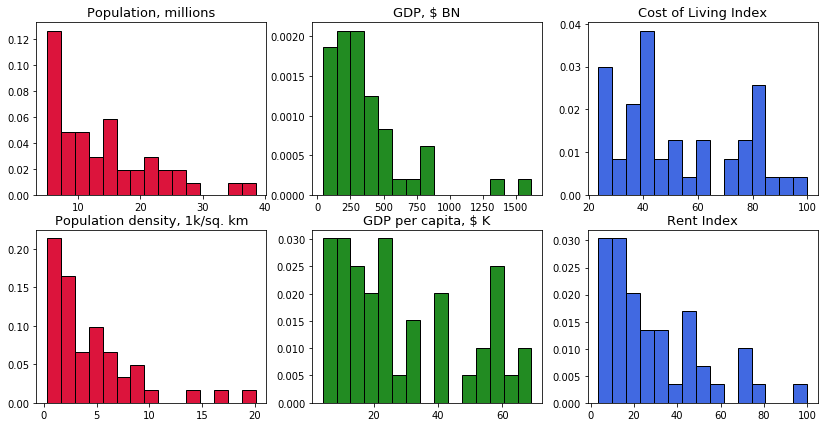

In [26]:
fig, axs = plt.subplots(2,3, figsize = (14,7))
plt.subplots_adjust(wspace = 0.2)

axs[0,0].hist(df_cities['Population']/1e6, bins = 15, density = True, facecolor = 'crimson', edgecolor = 'black', linewidth = 1)
axs[0,0].set_title('Population, millions', fontsize = 13)

axs[1,0].hist(df_cities['Density']/1e3, bins = 15, density = True, facecolor = 'crimson', edgecolor = 'black', linewidth = 1)
axs[1,0].set_title('Population density, 1k/sq. km', fontsize = 13)

axs[0,1].hist(df_cities['GDP_bn'], bins = 15, density = True, facecolor = 'forestgreen', edgecolor = 'black', linewidth = 1)
axs[0,1].set_title('GDP, $ BN', fontsize = 13)

axs[1,1].hist(df_cities['GDP_pc']/1e3, bins = 15, density = True, facecolor = 'forestgreen', edgecolor = 'black', linewidth = 1)
axs[1,1].set_title('GDP per capita, $ K', fontsize = 13)

axs[0,2].hist(df_cities['COL'], bins = 15, density = True, facecolor = 'royalblue', edgecolor = 'black', linewidth = 1)
axs[0,2].set_title('Cost of Living Index', fontsize = 13)

axs[1,2].hist(df_cities['RENT'], bins = 15, density = True, facecolor = 'royalblue', edgecolor = 'black', linewidth = 1)
axs[1,2].set_title('Rent Index', fontsize = 13)

<a id = '3.4.2'></a>
#### 3.4.2 Correlations between cost and GDP per capita

All cost indices show a strong positive correlation with per capita GDP. As expected, rent seems to be the most sensitive - a 1% increase in the per capita GDP of a city leads to a 0.8% increase in the rent on average. Note that since the GDP per capita values range over thousands of USD, and the cost indices can range 0-100, both the X and Y variables were cast to a logarithmic scale using the <b>numpy.log</b> function to reduce the errors in a simple linear regression.

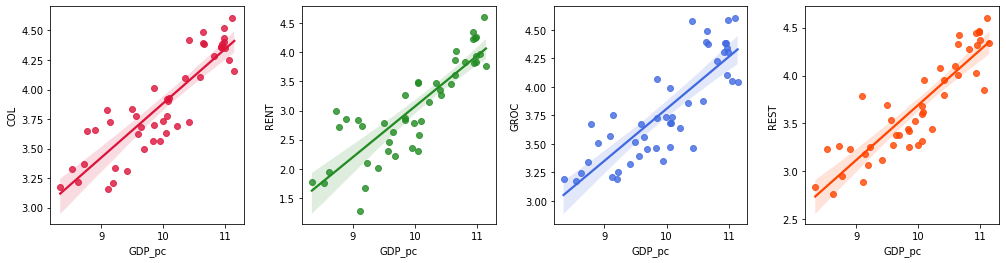

In [27]:
fig, axs = plt.subplots(1,4, figsize = (17,4))
plt.subplots_adjust(wspace = 0.3)
sns.regplot(x = np.log(df_cities['GDP_pc']), y = np.log(df_cities['COL']), ax = axs[0], color = 'crimson')
sns.regplot(x = np.log(df_cities['GDP_pc']), y = np.log(df_cities['RENT']), ax = axs[1], color = 'forestgreen')
sns.regplot(x = np.log(df_cities['GDP_pc']), y = np.log(df_cities['GROC']), ax = axs[2], color = 'royalblue')
sns.regplot(x = np.log(df_cities['GDP_pc']), y = np.log(df_cities['REST']), ax = axs[3], color = 'orangered')

In [28]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(np.log(df_cities[['GDP_pc']]), np.log(df_cities[['COL']]))
c1 = lm.coef_[0,0]
r1 = lm.score(np.log(df_cities[['GDP_pc']]), np.log(df_cities[['COL']]))
lm.fit(np.log(df_cities[['GDP_pc']]), np.log(df_cities[['RENT']]))
c2 = lm.coef_[0,0]
r2 = lm.score(np.log(df_cities[['GDP_pc']]), np.log(df_cities[['RENT']]))
lm.fit(np.log(df_cities[['GDP_pc']]), np.log(df_cities[['GROC']]))
c3 = lm.coef_[0,0]
r3 = lm.score(np.log(df_cities[['GDP_pc']]), np.log(df_cities[['GROC']]))
lm.fit(np.log(df_cities[['GDP_pc']]), np.log(df_cities[['REST']]))
c4 = lm.coef_[0,0]
r4 = lm.score(np.log(df_cities[['GDP_pc']]), np.log(df_cities[['REST']]))

data = {'Index':['Cost of Living', 'Rent', 'Groceries', 'Restaurants'], 'Coefficient':[c1, c2, c3, c4], 'R^2':[r1, r2, r4, r4]}
pd.DataFrame(data).sort_values('Coefficient', ascending = False)

,Index,Coefficient,R^2
1,Rent,0.871431,0.723006
3,Restaurants,0.577262,0.789755
0,Cost of Living,0.461144,0.769275
2,Groceries,0.456155,0.789755


<a id = '3.4.3'></a>
#### 3.4.3 Correlations between cost and population density

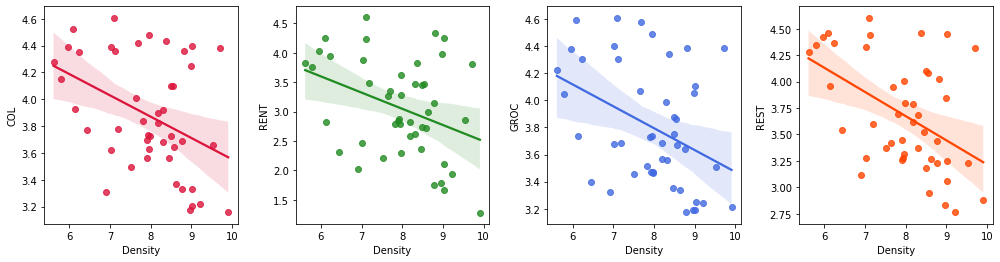

In [29]:
fig, axs = plt.subplots(1,4, figsize = (17,4))
plt.subplots_adjust(wspace = 0.3)
sns.regplot(x = np.log(df_cities['Density']), y = np.log(df_cities['COL']), ax = axs[0], color = 'crimson')
sns.regplot(x = np.log(df_cities['Density']), y = np.log(df_cities['RENT']), ax = axs[1], color = 'forestgreen')
sns.regplot(x = np.log(df_cities['Density']), y = np.log(df_cities['GROC']), ax = axs[2], color = 'royalblue')
sns.regplot(x = np.log(df_cities['Density']), y = np.log(df_cities['REST']), ax = axs[3], color = 'orangered')

In [30]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(np.log(df_cities[['Density']]), np.log(df_cities[['COL']]))
c1 = lm.coef_[0,0]
r1 = lm.score(np.log(df_cities[['Density']]), np.log(df_cities[['COL']]))
lm.fit(np.log(df_cities[['Density']]), np.log(df_cities[['RENT']]))
c2 = lm.coef_[0,0]
r2 = lm.score(np.log(df_cities[['Density']]), np.log(df_cities[['RENT']]))
lm.fit(np.log(df_cities[['Density']]), np.log(df_cities[['GROC']]))
c3 = lm.coef_[0,0]
r3 = lm.score(np.log(df_cities[['Density']]), np.log(df_cities[['GROC']]))
lm.fit(np.log(df_cities[['Density']]), np.log(df_cities[['REST']]))
c4 = lm.coef_[0,0]
r4 = lm.score(np.log(df_cities[['Density']]), np.log(df_cities[['REST']]))

data = {'Index':['Cost of Living', 'Rent', 'Groceries', 'Restaurants'], 'Coefficient':[c1, c2, c3, c4], 'R^2':[r1, r2, r4, r4]}
pd.DataFrame(data).sort_values('Coefficient', ascending = False)

,Index,Coefficient,R^2
0,Cost of Living,-0.158952,0.166108
2,Groceries,-0.161414,0.225821
3,Restaurants,-0.228973,0.225821
1,Rent,-0.275501,0.131331


<a id = '3.4.4'></a>
#### 3.4.4 Correlations between density and GDP

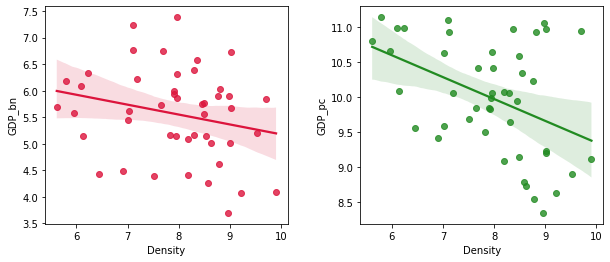

In [31]:
ig, axs = plt.subplots(1,2, figsize = (10,4))
plt.subplots_adjust(wspace = 0.3)
sns.regplot(x = np.log(df_cities['Density']), y = np.log(df_cities['GDP_bn']), ax = axs[0], color = 'crimson')
sns.regplot(x = np.log(df_cities['Density']), y = np.log(df_cities['GDP_pc']), ax = axs[1], color = 'forestgreen')

In [32]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(np.log(df_cities[['Density']]), np.log(df_cities[['GDP_bn']]))
c1 = lm.coef_[0,0]
r1 = lm.score(np.log(df_cities[['Density']]), np.log(df_cities[['GDP_bn']]))

lm.fit(np.log(df_cities[['Density']]), np.log(df_cities[['GDP_pc']]))
c2 = lm.coef_[0,0]
r2 = lm.score(np.log(df_cities[['Density']]), np.log(df_cities[['GDP_pc']]))

data = {'GDP measure':['Total', 'Per Capita'], 'Coefficient':[c1, c2], 'R^2':[r1, r2]}
pd.DataFrame(data).sort_values('Coefficient', ascending = False)

,GDP measure,Coefficient,R^2
0,Total,-0.186048,0.055519
1,Per Capita,-0.312725,0.177735


<a id = '3.4.5'></a>
#### 3.4.5 Correlations between area and other demographic variables

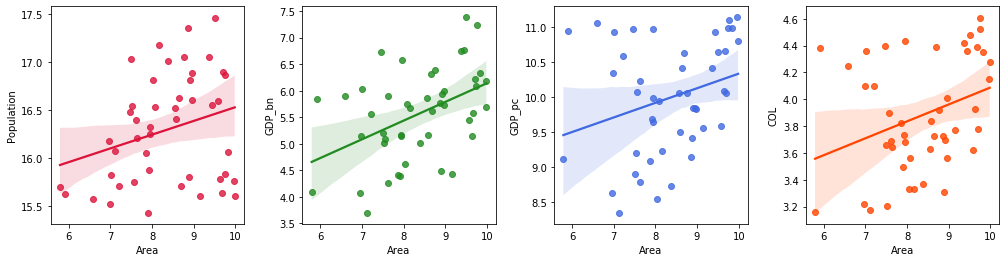

In [33]:
fig, axs = plt.subplots(1,4, figsize = (17,4))
plt.subplots_adjust(wspace = 0.3)
sns.regplot(x = np.log(df_cities['Area']), y = np.log(df_cities['Population']), ax = axs[0], color = 'crimson')
sns.regplot(x = np.log(df_cities['Area']), y = np.log(df_cities['GDP_bn']), ax = axs[1], color = 'forestgreen')
sns.regplot(x = np.log(df_cities['Area']), y = np.log(df_cities['GDP_pc']), ax = axs[2], color = 'royalblue')
sns.regplot(x = np.log(df_cities['Area']), y = np.log(df_cities['COL']), ax = axs[3], color = 'orangered')

In [34]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(np.log(df_cities[['Area']]), np.log(df_cities[['Population']]))
c1 = lm.coef_[0,0]
r1 = lm.score(np.log(df_cities[['Area']]), np.log(df_cities[['Population']]))

lm.fit(np.log(df_cities[['Area']]), np.log(df_cities[['GDP_bn']]))
c2 = lm.coef_[0,0]
r2 = lm.score(np.log(df_cities[['Area']]), np.log(df_cities[['GDP_bn']]))

lm.fit(np.log(df_cities[['Area']]), np.log(df_cities[['GDP_pc']]))
c3 = lm.coef_[0,0]
r3 = lm.score(np.log(df_cities[['Area']]), np.log(df_cities[['GDP_pc']]))

lm.fit(np.log(df_cities[['Area']]), np.log(df_cities[['COL']]))
c4 = lm.coef_[0,0]
r4 = lm.score(np.log(df_cities[['Area']]), np.log(df_cities[['COL']]))

data = {'Parameter':['Population', 'GDP, Total', 'GDP, per capita', 'Cost of Living'], 'Coefficient':[c1, c2, c3, c4], 'R^2':[r1, r2, r4, r4]}
pd.DataFrame(data).sort_values('Coefficient', ascending = False)

,Parameter,Coefficient,R^2
1,"GDP, Total",0.352221,0.202869
2,"GDP, per capita",0.208824,0.106558
0,Population,0.143397,0.076827
3,Cost of Living,0.126086,0.106558


<a id = '4'></a>
## 4. Clustering the cities

Now that we have both the datasets ready, we begin clustering the countries. 

 <a id = '4.1'></a>
### 4.1 Clustering using demographic variables

The input to the k means model is defined by taking the numeric columns from the dataframe <b>df_cities</b>. Using the standard scaler, this is then transformed to a z-values matrix and provided as an input to the k-means clustering method, which then sorts the data into five clusters. We then check the number of countries that have been classified into each cluster. Using the coordinate data, we then plot a color-coded map to show the location of the cities and their clusters. The resulting labels are stored in the dataframe <b>df_results</b>.

In [55]:
df_results = df_cities.copy()

#Define the x matrix
x_col = ['Population', 'Area', 'Density', 'GDP_bn', 'GDP_pc', 'COL', 'RENT', 'GROC', 'REST']
x = df_cities[x_col]

#Scale the data
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

#Fit the data to the model
num_clusters = 5
k_means = KMeans(n_clusters = num_clusters, init = 'k-means++', n_init = 500, max_iter = 500)
k_means.fit(x)
labels = k_means.labels_
df_results['Labels_A'] = labels
df_results['Labels_A'].value_counts()

0    21
2    8 
1    8 
4    6 
3    3 
Name: Labels_A, dtype: int64

In [56]:
#Plotting the results on the map
worldmap = folium.Map(location=[0,0], zoom_start = 2)
colors = ['crimson', 'forestgreen', 'royalblue', 'orangered', 'gray']

for ct, cnt, lat, long, cls in zip(df_results['Name'], df_results['Country'], df_results['Latitude'], df_results['Longitude'], df_results['Labels_A']):
    label = str(ct) + ',' + cnt + ',' + 'Cluster' + str(cls)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, long],
        radius = 4,
        popup = label,
        color = colors[cls],
        fill = True,
        fill_color = colors[cls],
        fill_opacity = 0.7,
        parse_html = False).add_to(worldmap)

worldmap

We now need to understand the characteristics of each cluster. In order to do so, we group the <b>df_results</b> dataframe by the cluster numbers, and return the mean value of each column. Furthermore, I have written a code that loops through the results dataframe, and generates a string that contains the names of the cities that lie in each cluster. This is then passed as a new column to the output dataframe <b>df_resultsA</b> which now stores the summary of clusters according to demographic clustering.

In [57]:
#create a list to store names of all countries in a cluster
city_list = ['', '', '', '', '']

#populate the list with the city names
for index, rows in df_results.iterrows():
    clusternum = df_results.at[index, 'Labels_A']
    city_list[clusternum] = city_list[clusternum] + df_results.at[index, 'Name'] + ', '

#create the output dataframe and add cities and color columns to it
df_resultsA = df_results.groupby('Labels_A').mean()
df_resultsA['Cities'] = city_list
df_resultsA['Color'] = colors
df_resultsA.drop(['Latitude', 'Longitude'], axis=1, inplace = True)
df_resultsA = df_resultsA.reset_index(drop=False).round(1)
df_resultsA

,Labels_A,Population,Area,Density,GDP_bn,GDP_pc,COL,RENT,GROC,REST,Cities,Color
0,0,14322316.1,6464.5,2936.7,266.4,18480.8,41.6,17.1,37.9,32.7,"Shanghai, Mexico City, Beijing, Buenos Aires, Istanbul, Rio de Janeiro, Guangzhou, Moscow, Shenzhen, Jakarta, Lima, Bangkok, Chengdu, Ho Chi Minh City, Kuala Lumpur, Riyadh, Santiago, Pune, Belo Horizonte, Johannesburg, Guadalajara,",crimson
1,1,8088271.5,1890.4,6862.6,423.6,50600.3,74.4,50.4,66.6,68.3,"Paris, London, Hong Kong, Madrid, Toronto, Singapore, Philadelphia, Barcelona,",forestgreen
2,2,17557500.0,2149.1,10051.3,129.8,7175.8,27.6,9.2,26.3,21.8,"Delhi, Cairo, Mumbai, Kolkata, Manila, Chennai, Hyderabad, Surat,",royalblue
3,3,28354666.7,14157.0,2085.9,1288.6,47271.9,90.4,55.2,95.4,68.9,"Tokyo, New York, Seoul,",orangered
4,4,8593312.5,17863.8,528.3,484.4,55842.4,77.4,56.1,75.2,80.5,"Los Angeles, Chicago, Houston, Miami, Atlanta, Washington, D.C.,",gray


#### Part 4b: Clustering by using only location/venue data

In [58]:
#Define the x matrix
x_col = ['City', 'City Lat', 'City Long']
x = df_grouped.drop(x_col, axis = 1)

#Fit the data to the model
num_clusters = 5
k_means = KMeans(n_clusters = num_clusters, init = 'k-means++', n_init = 500, max_iter = 500)
k_means.fit(x)
labels = k_means.labels_

df_grouped['Labels_B'] = labels
df_grouped['Labels_B'].value_counts()

2    17
0    12
1    8 
3    7 
4    2 
Name: Labels_B, dtype: int64

In [59]:
#Plotting the results on the map
worldmap = folium.Map(location=[0,0], zoom_start = 2)
colors = ['crimson', 'forestgreen', 'royalblue', 'orangered', 'gray']

for ct, lat, long, cls in zip(df_grouped['City'], df_grouped['City Lat'], df_grouped['City Long'], df_grouped['Labels_B']):
    label = str(ct) + ', Cluster ' + str(cls)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, long],
        radius = 4,
        popup = label,
        color = colors[cls],
        fill = True,
        fill_color = colors[cls],
        fill_opacity = 0.7,
        parse_html = False).add_to(worldmap)

worldmap

In [64]:
#Finding the top 5 venues in each cluster
x_col = ['City', 'City Lat', 'City Long']
x = df_grouped.drop(x_col, axis = 1)

df_resultsB = pd.DataFrame()

for i in range(0, num_clusters):
    list_i = x[x['Labels_B'] == i].drop('Labels_B', axis = 1).sum().sort_values(ascending = False).to_frame().reset_index().head(5)['index'].str.replace('Venue Category_', '')
    cname = 'Cluster ' + str(i)
    df_resultsB[cname] = list_i

df_resultsB.columns = ['Cluster 0: ' + colors[0],
                      'Cluster 1: ' + colors[1],
                      'Cluster 2: ' + colors[2],
                      'Cluster 3: ' + colors[3],
                      'Cluster 4: ' + colors[4]]
df_resultsB

,Cluster 0: crimson,Cluster 1: forestgreen,Cluster 2: royalblue,Cluster 3: orangered,Cluster 4: gray
0,Hotel,Hotel,Park,Indian Restaurant,Ice Cream Shop
1,Coffee Shop,Shopping Mall,Coffee Shop,Hotel,Mexican Restaurant
2,Café,Coffee Shop,Hotel,Café,Taco Place
3,Park,Park,Bakery,Multiplex,Seafood Restaurant
4,Bakery,Chinese Restaurant,Trail,Restaurant,Bakery


In [65]:
#create a list to store names of all countries in a cluster
city_list = ['', '', '', '', '']

#populate the list with the city names
for index, rows in df_grouped.iterrows():
    clusternum = df_grouped.at[index, 'Labels_B']
    city_list[clusternum] = city_list[clusternum] + df_grouped.at[index, 'City'] + ', '

df_resultsB2 = pd.DataFrame({'Cluster':[0,1,2,3,4], 'Cities':city_list, 'Color':colors})
df_resultsB2

,Cluster,Cities,Color
0,0,"Barcelona, Beijing, Belo Horizonte, Buenos Aires, Cairo, Ho Chi Minh City, Istanbul, Johannesburg, Manila, Riyadh, Singapore, Tokyo,",crimson
1,1,"Bangkok, Chengdu, Guangzhou, Hong Kong, Jakarta, Kuala Lumpur, Shanghai, Shenzhen,",forestgreen
2,2,"Atlanta, Chicago, Houston, Lima, London, Los Angeles, Madrid, Miami, Moscow, New York, Paris, Philadelphia, Rio de Janeiro, Santiago, Seoul, Toronto, Washington, D.C.,",royalblue
3,3,"Chennai, Delhi, Hyderabad, Kolkata, Mumbai, Pune, Surat,",orangered
4,4,"Guadalajara, Mexico City,",gray


## 5. Results and Discussion

In this notebook, we have used two different approaches for clustering 46 of the world's largest cities - using demographic data and venue distribution. We used data from Wikipedia and Numbero to populate the demographics table, and the FourSquare API was used to obtain venue data.

While analysing the demographic data, a strong correlation was observed between the cost indices and the GDP per capita, which indicates that the wealthier cities are also more expensive to live in. The k-means algorithm clustered the cities into the following five categories.

In [66]:
df_resultsA

,Labels_A,Population,Area,Density,GDP_bn,GDP_pc,COL,RENT,GROC,REST,Cities,Color
0,0,14322316.1,6464.5,2936.7,266.4,18480.8,41.6,17.1,37.9,32.7,"Shanghai, Mexico City, Beijing, Buenos Aires, Istanbul, Rio de Janeiro, Guangzhou, Moscow, Shenzhen, Jakarta, Lima, Bangkok, Chengdu, Ho Chi Minh City, Kuala Lumpur, Riyadh, Santiago, Pune, Belo Horizonte, Johannesburg, Guadalajara,",crimson
1,1,8088271.5,1890.4,6862.6,423.6,50600.3,74.4,50.4,66.6,68.3,"Paris, London, Hong Kong, Madrid, Toronto, Singapore, Philadelphia, Barcelona,",forestgreen
2,2,17557500.0,2149.1,10051.3,129.8,7175.8,27.6,9.2,26.3,21.8,"Delhi, Cairo, Mumbai, Kolkata, Manila, Chennai, Hyderabad, Surat,",royalblue
3,3,28354666.7,14157.0,2085.9,1288.6,47271.9,90.4,55.2,95.4,68.9,"Tokyo, New York, Seoul,",orangered
4,4,8593312.5,17863.8,528.3,484.4,55842.4,77.4,56.1,75.2,80.5,"Los Angeles, Chicago, Houston, Miami, Atlanta, Washington, D.C.,",gray


In order to analyze this further, we represent each of these values on a radar plot. Since this functionality is not available in python, the dataset was exported to Ms-Excel and the radar chart was plotted there. The columns contain information which differ by orders of magnitude. For the sake of plotting, each value was divided by the maximum value in its column to ensure that all numerical values lie between 0 and 1.

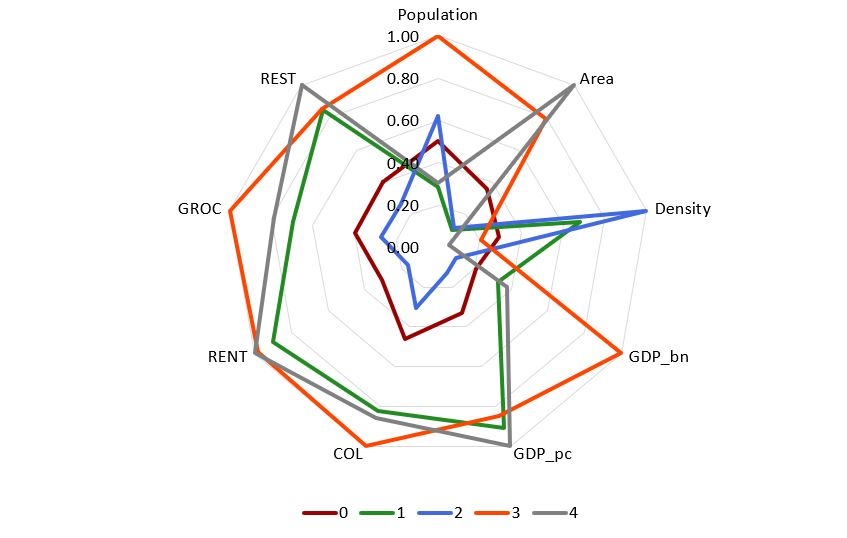

The five clusters can be understood as follows
1. <b><font color = 'crimson'>Cluster 0</font></b>: Bulk of the cities fall into this category. They do not have any marked characteristic, as all the parameters are average and no distinction is seen. From a geographical perspective, these cities are all located in develping countries.
2. <b><font color = 'forestgreen'>Cluster 1</font></b>: These cities are marked by small size, moderately high population density, high GDP per capita and high cost indices. Most of them are European.
3. <b><font color = 'royalblue'>Cluster 2</font></b>: These cities are characterized by their small size, low GDP, low cost indices and extremely high population density. One can expect them to be high poverty, congested cities. Most of them are located in India.
4. <b><font color = 'orangered'>Cluster 3</font></b>: These cities have large populations, extremely high GDPs and cost indices, but low population density. Only three cities - NYC, Tokyo and Seoul fall in this category.
5. <b><font color = 'gray'>Cluster 4</font></b>: These cities are similar to cluster 4 but are even bigger in size. They can best be described as rich, large cities. They are all located in the USA.

Clustering based on venue distribution around the city centre yielded the following five clusters:

In [68]:
df_resultsB

,Cluster 0: crimson,Cluster 1: forestgreen,Cluster 2: royalblue,Cluster 3: orangered,Cluster 4: gray
0,Hotel,Hotel,Park,Indian Restaurant,Ice Cream Shop
1,Coffee Shop,Shopping Mall,Coffee Shop,Hotel,Mexican Restaurant
2,Café,Coffee Shop,Hotel,Café,Taco Place
3,Park,Park,Bakery,Multiplex,Seafood Restaurant
4,Bakery,Chinese Restaurant,Trail,Restaurant,Bakery


While the top 5 categories in each cluster are self - explanatory, some trends in their geographical location are observed. This can be explained by the data obtained from FourSquare - while there are some common venues across all cities (hotels, cafes and coffee shops) certain cities are marked by a higher concentration of a certain kind of venue.

1. <b><font color = 'crimson'>Cluster 0</font></b> is located across all continents with no special characteristics.
2. <b><font color = 'forestgreen'>Cluster 1</font></b> is mostly present in SEA and China, marked by Chinese restaurants.
3. <b><font color = 'royalblue'>Cluster 2</font></b> has cities in the US and Europe, marked by a high density of parks.
4. <b><font color = 'orangered'>Cluster 3</font></b> contains cities that are all located in India, with Indian restaurants and multiplexes among the top 5 venue categories.
5. <b><font color = 'gray'>Cluster 4</font></b> contains two Mexican cities, marked by taco places and mexican restaurants.

## 6. Conclusion

In this report, we tried to cluster the world's largest cities into 5 categories, based on both demographic and venue data sourced from FourSquare. While 50% of the dataset was clustered into one category, there were some cities that stood out because of one or more defining characteristics.

In this exercise, we used the GDP per capita as a measure of the city's wealth. However, income levels (Average income or its distribution) might be a better representation of the same, because the GDP also contains government expenditure. Furthermore, the cost indices could be replaced by actual costs of key commodities. The purchasing power of the local currency should also be considered as a parameter, as that affects the value one can extract from their salary.

As far as the foursquare data is concerned, the current exercise did not distinguish between types of venues. However, when making a decision to move overseas, some venues are more important than others. For example, banks, schools and medical facilities might be considered more important than restaurants. For a better analysis, 4 or 5 such macro categories can be defined and the number of venues that fall under each of them can then be used for comparison.